### Import relevant libraries

In [89]:
from semopy import Model, calc_stats, semplot
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import seaborn as sns
from semopy.inspector import inspect

### Import the dataset

In [90]:
df = pd.read_csv("Welzijnsmonitor2025_scaled_normalised_UTF8.csv", sep=";")

In [91]:
Q1 = df['StPunt_beh'].quantile(0.25)
Q3 = df['StPunt_beh'].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (df['StPunt_beh'] < (Q1 - 1.5 * IQR)) | (df['StPunt_beh'] > (Q3 + 1.5 * IQR))
outlier_counts = outlier_mask.sum()

print("\nNumber of outliers per numeric variable:")
print(outlier_counts)

df = df[~outlier_mask].copy()
print("\nNew shape after removing outliers:", df.shape)



Number of outliers per numeric variable:
231

New shape after removing outliers: (1281, 76)


### Creating the model

In [92]:
model_desc = """
# measurement model

Wellbeing =~ Bevl_1 + Bevl_2 + Bevl_3 + Cogn_Eng1_5 + Cogn_Eng1_6 + Cogn_Eng2_8 + Mot_Stress_1 + Mot_Stress_4
Negative_Outcomes =~ StopInt + Vertr
Positive_Outcomes =~ Cijfer_huidig_1 + StPunt_beh
Stressors =~ Onnodige_stress_1 + Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_7
Response_to_Stress =~ Burn1_1 + Burn1_2 + Burn1_3 + Burn1_4 + Depr_1 + Depr_2 + Depr_3 + Depr_4 + Depr_5 + Depr_6 + Depr_7 + Depr_8 + Mot_Stress_2
Energy_Sources =~ Cogn_Eng2_1 + Cogn_Eng2_4 + Cogn_Eng2_5 + Cogn_Eng2_7 + Partici1_1 + Partici1_2 + Partici1_3 + Partici1_4

# Covariances (two-headed arrows in the diagram)
Response_to_Stress ~~ Wellbeing
Stressors ~~ Energy_Sources
Negative_Outcomes ~~ Positive_Outcomes

# Regressions
Response_to_Stress ~ Stressors + Energy_Sources
Wellbeing ~ Stressors + Energy_Sources

Negative_Outcomes ~ Response_to_Stress + Wellbeing
Positive_Outcomes ~ Wellbeing + Response_to_Stress
"""

In [93]:
model = Model(model_desc)
model.fit(df)

df_imputed = model.predict(df)
latent_scores = model.predict_factors(df_imputed)

# Export the model with the new latent variables and their descriptive statistics

In [94]:
latent_scores.to_csv("latent_variable_scores.csv", index=False)
latent_scores.describe()

,Energy_Sources,Negative_Outcomes,Positive_Outcomes,Response_to_Stress,Stressors,Wellbeing
count,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03,1.281000e+03
mean,-9.984207e-17,-9.013520e-17,-4.160086e-17,1.774970e-16,-6.101460e-17,-4.409691e-16
std,3.284537e-01,1.808136e-01,2.602716e-01,5.873242e-01,6.092170e-01,5.249338e-01
min,-9.090356e-01,-3.784685e-01,-1.408519e+00,-1.287276e+00,-1.545352e+00,-2.033608e+00
25%,-2.268775e-01,-1.290175e-01,-1.050072e-01,-4.433910e-01,-4.470862e-01,-2.673135e-01
50%,-2.246746e-02,-2.699082e-02,4.199964e-02,-4.421428e-02,3.489921e-02,8.794550e-02
75%,1.969498e-01,9.397281e-02,1.583751e-01,3.847415e-01,4.573911e-01,3.397297e-01
max,1.139708e+00,7.413199e-01,5.726026e-01,2.090070e+00,1.397591e+00,1.225732e+00


In [95]:
latents = set(model.vars['latent'])
observeds = set(model.vars['observed'])

est = model.inspect(std_est=True)

# Factor loadings = observed ~ latent
loadings = est[
    (est['op'] == '~') &
    (est['lval'].isin(observeds)) &
    (est['rval'].isin(latents))
]

print("Factor loadings:")
display(loadings)

Factor loadings:


,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
8,Bevl_1,~,Wellbeing,1.000000,0.648959,-,-,-
9,Bevl_2,~,Wellbeing,1.145958,0.794377,0.047717,24.015491,0.0
10,Bevl_3,~,Wellbeing,1.106807,0.694401,0.051328,21.563532,0.0
11,Cogn_Eng1_5,~,Wellbeing,1.163424,0.686353,0.054477,21.356261,0.0
12,Cogn_Eng1_6,~,Wellbeing,0.909023,0.542370,0.052144,17.432921,0.0
13,Cogn_Eng2_8,~,Wellbeing,0.683751,0.419960,0.049525,13.80618,0.0
14,Mot_Stress_1,~,Wellbeing,1.163159,0.764510,0.049902,23.308807,0.0
15,Mot_Stress_4,~,Wellbeing,1.233775,0.850540,0.048845,25.259187,0.0
16,StopInt,~,Negative_Outcomes,1.000000,0.506323,-,-,-
17,Vertr,~,Negative_Outcomes,2.154548,0.429043,0.202084,10.661629,0.0


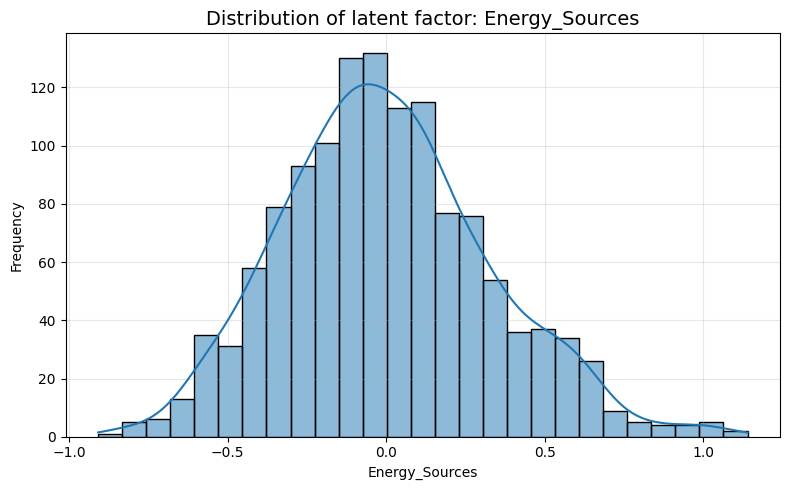

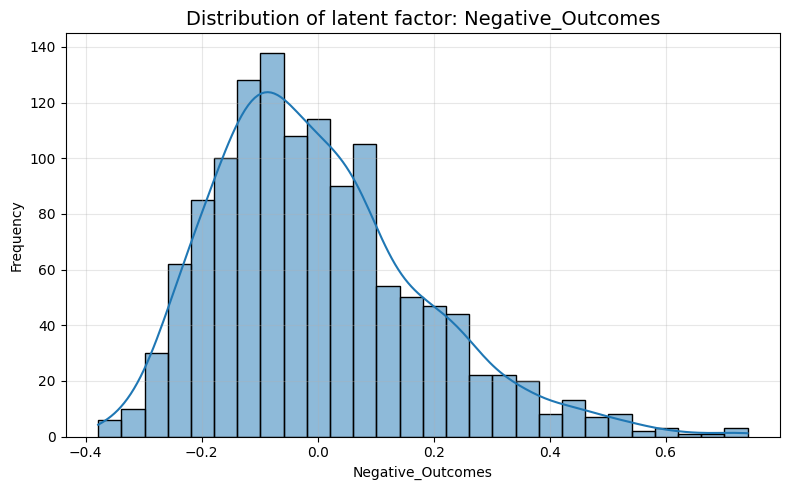

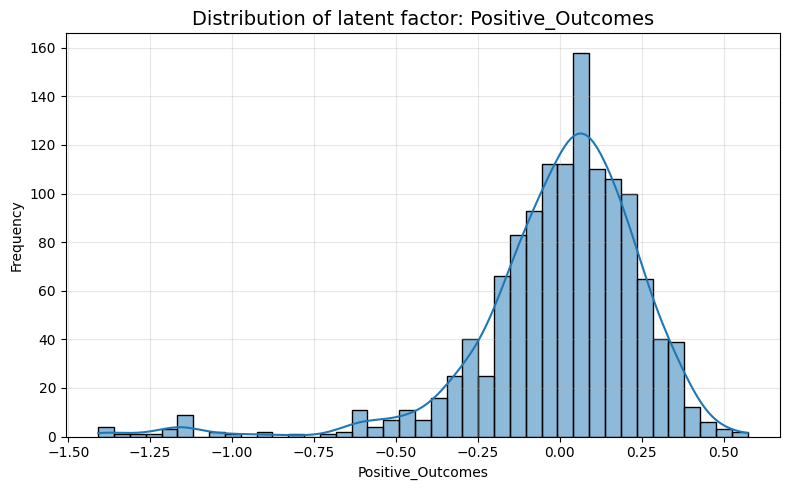

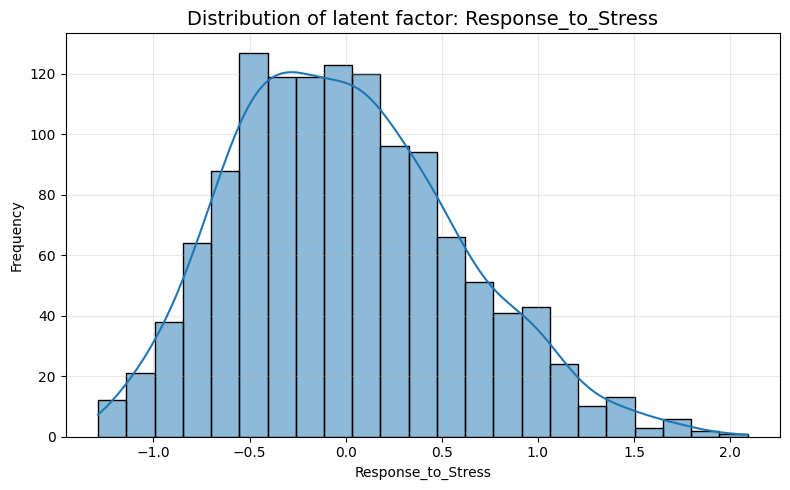

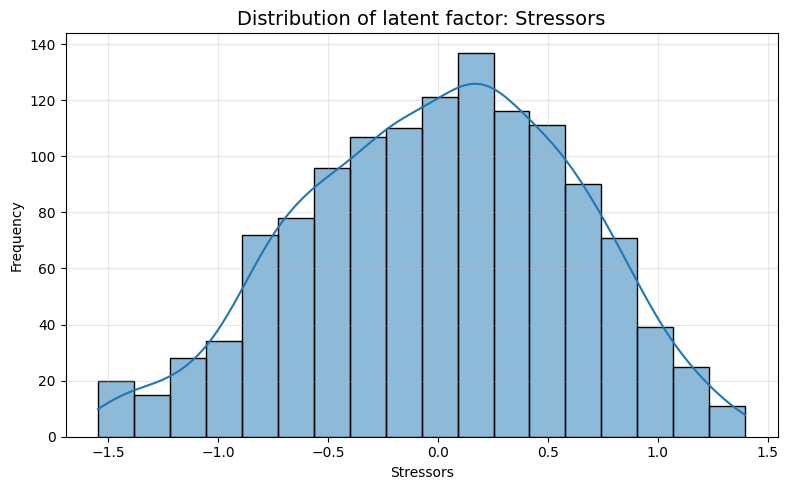

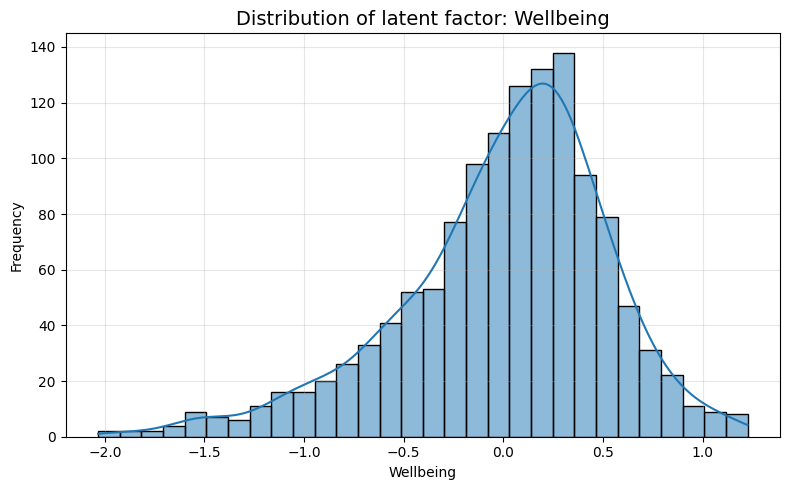

In [96]:
# Plot histogram for each latent variable
for col in latent_scores.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(latent_scores[col], kde=True)
    plt.title(f"Distribution of latent factor: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Correlation matrix

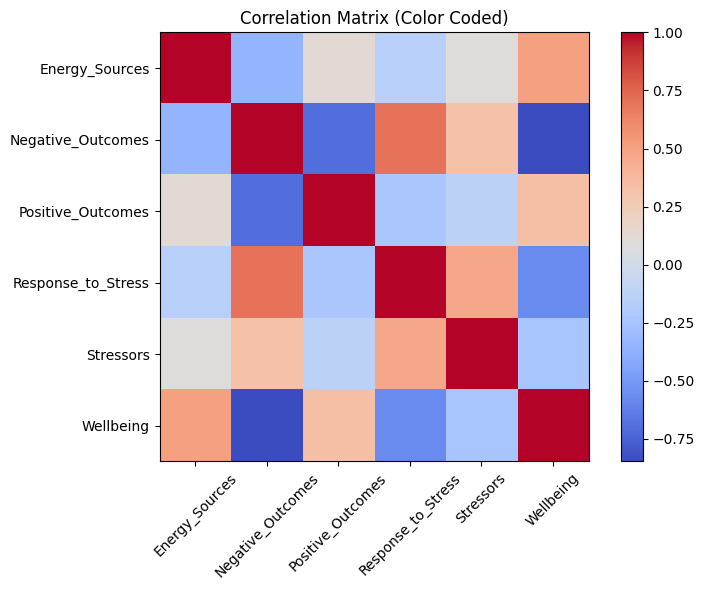

In [97]:
corr_matrix = latent_scores.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Correlation Matrix (Color Coded)")
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# print(corr_matrix)

### Calculate fit indices

In [98]:
stats = calc_stats(model)

print("=== Model Fit Statistics ===")
print(stats.T)

=== Model Fit Statistics ===
                      Value
DoF              729.000000
DoF Baseline     780.000000
chi2            5533.653712
chi2 p-value       0.000000
chi2 Baseline  20133.753088
CFI                0.751746
GFI                0.725155
AGFI               0.705928
NFI                0.725155
TLI                0.734378
RMSEA              0.071757
AIC              173.360416
BIC              642.501479
LogLik             4.319792


### Create and save the path diagram

In [99]:
g = semplot(model, "pd3.png")

### Extract model coefficients

In [100]:
coefficients = model.inspect()
coefficients.to_csv("model_coefficients.csv")
coefficients.to_excel("model_coefficients.xlsx")

In [101]:
def pretty_sem_latent_explicit(model):
    df = model.inspect().copy()

    # List of latent relationships as (lval, op, rval)
    wanted = [
        # covariances
        ("Response_to_Stress", "~~", "Wellbeing"),
        ("Stressors", "~~", "Energy_Sources"),
        ("Negative_Outcomes", "~~", "Positive_Outcomes"),

        # regressions
        ("Response_to_Stress", "~",  "Stressors"),
        ("Response_to_Stress", "~",  "Energy_Sources"),
        ("Wellbeing",          "~",  "Stressors"),
        ("Wellbeing",          "~",  "Energy_Sources"),
        ("Negative_Outcomes",  "~",  "Response_to_Stress"),
        ("Negative_Outcomes",  "~",  "Wellbeing"),
        ("Positive_Outcomes",  "~",  "Wellbeing"),
        ("Positive_Outcomes",  "~",  "Response_to_Stress"),
    ]

    wanted_df = pd.DataFrame(wanted, columns=["lval", "op", "rval"])

    # Inner join to keep only those rows
    df = df.merge(wanted_df, on=["lval", "op", "rval"], how="inner")

    # Label type + from/to
    df["Type"] = df["op"].map({"~": "Regression", "~~": "Covariance"})
    df["From"] = df["lval"]
    df["To"]   = df["rval"]

    # Clean p-values (handles "<0.001")
    p_clean = df["p-value"].astype(str).str.replace("<", "", regex=False)
    df["p_value"] = pd.to_numeric(p_clean, errors="coerce")

    # Significance stars
    def stars(p):
        if pd.isna(p): return ""
        if p < 0.001: return "***"
        if p < 0.01:  return "**"
        if p < 0.05:  return "*"
        if p < 0.10:  return "."
        return ""

    df["Sig"] = df["p_value"].apply(stars)

    # Numeric & rounded
    for col in ["Estimate", "Std. Err", "z-value", "p_value"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(4)

    # Final table
    nice = df[[
        "Type", "From", "To",
        "Estimate", "Std. Err", "z-value", "p_value", "Sig"
    ]].copy()

    nice = nice.rename(columns={"Std. Err": "Std_Err"})

    return nice

latent_table = pretty_sem_latent_explicit(model)
latent_table   # last line in the cell → shows a nice table

,Type,From,To,Estimate,Std_Err,z-value,p_value,Sig
0,Regression,Response_to_Stress,Stressors,0.4003,0.0358,11.1958,0.0000,***
1,Regression,Response_to_Stress,Energy_Sources,-0.2652,0.0561,-4.7292,0.0000,***
2,Regression,Wellbeing,Stressors,-0.1911,0.0267,-7.1443,0.0000,***
3,Regression,Wellbeing,Energy_Sources,0.6757,0.0672,10.0530,0.0000,***
4,Regression,Negative_Outcomes,Response_to_Stress,0.0999,0.0192,5.2142,0.0000,***
5,Regression,Negative_Outcomes,Wellbeing,-0.2225,0.0235,-9.4717,0.0000,***
6,Regression,Positive_Outcomes,Wellbeing,0.1426,0.0307,4.6396,0.0000,***
7,Regression,Positive_Outcomes,Response_to_Stress,-0.0243,0.0266,-0.9148,0.3603,
8,Covariance,Response_to_Stress,Wellbeing,-0.1246,0.0115,-10.8231,0.0000,***
9,Covariance,Stressors,Energy_Sources,0.0167,0.0086,1.9579,0.0502,.
